357504
357498
                         open     close     volume  Daily_Return  \
datetime                                                           
2018-01-01 09:40:00  13399.99  13351.71  32.528288     -0.003604   
2018-01-01 09:45:00  13354.99  13330.05  36.474570     -0.001622   
2018-01-01 09:50:00  13336.98  13408.99  17.610242      0.005922   
2018-01-01 09:55:00  13408.99  13430.00  16.478325      0.001567   
2018-01-01 10:00:00  13429.99  13445.35  24.084508      0.001143   

                     Next_Day_Return        RSI  Signal_Line       ROC  \
datetime                                                                 
2018-01-01 09:40:00        -0.001622  54.324571    67.078497 -1.024836   
2018-01-01 09:45:00         0.005922  48.449522    72.490605 -0.788405   
2018-01-01 09:50:00         0.001567  47.130560    74.297678 -0.007755   
2018-01-01 09:55:00         0.001143  47.790564    72.612650  0.022716   
2018-01-01 10:00:00         0.001238  44.600351    67.715670  0.3

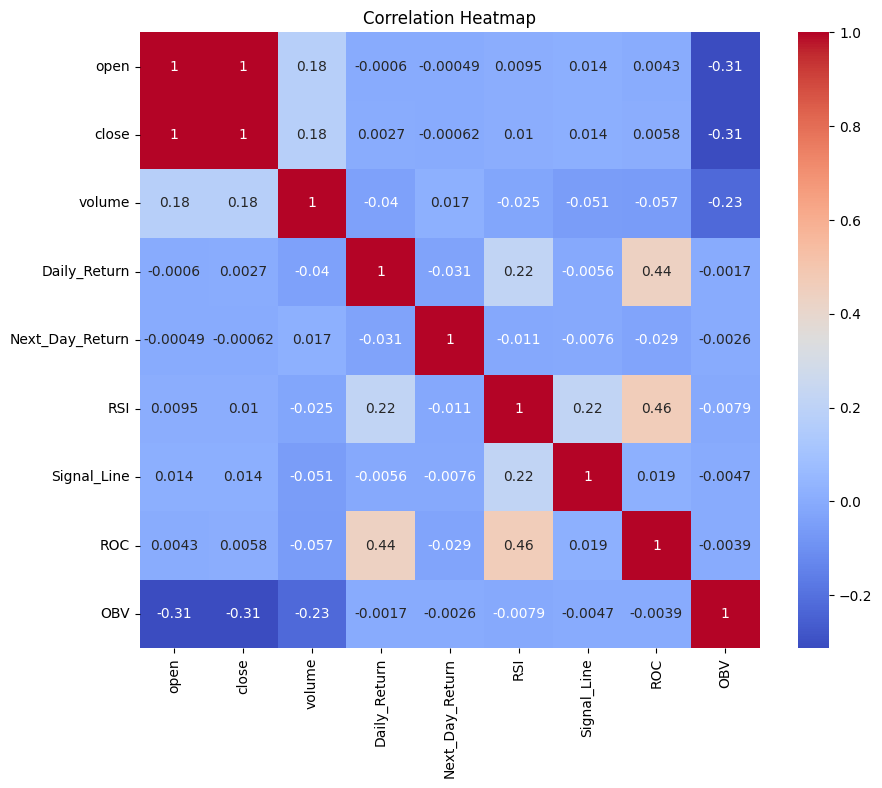

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)

def get_data(timeframe):
    return read_file("../../data/btcusdt_" + timeframe + "_total.csv")

time_frame = "5m"
# Load data
df = get_data(time_frame)
df.head()

df['Daily_Return'] = df['close'].pct_change()
df['Next_Day_Return'] = df['Daily_Return'].shift(-1)
window = 14
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
short_window = 12
long_window = 26
signal_window = 9
df['Short_MA'] = df['close'].rolling(window=short_window).mean()
df['Long_MA'] = df['close'].rolling(window=long_window).mean()
df['MACD'] = df['Short_MA'] - df['Long_MA']
df['Signal_Line'] = df['MACD'].rolling(window=signal_window).mean()
n = 5
df['ROC'] = df['close'].pct_change(n) * 100
df['OBV'] = np.where(df['close'] > df['close'].shift(1), df['volume'], -df['volume'])
df['OBV'] = df['OBV'].cumsum()
df_ = df.drop(['high', 'low', 'MACD', 'Short_MA', 'Long_MA'], axis=1)
df_ = df_.drop(df_.index[:50])
print(len(df_))
df_ = df_.dropna()
print(len(df_))
print(df_.head())

# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
df_.to_csv("../logs/junk" + time_frame + ".csv")

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_, test_size=0.5, shuffle=False)

# Create the linear regression model
model = LinearRegression()
# Define the independent variables
X_train = df_train.drop('Next_Day_Return', axis=1)
X_train = X_train.drop('open', axis=1)
X_val = df_val.drop('Next_Day_Return', axis=1)
X_val = X_val.drop('open', axis=1)
# Define the dependent variable
y_train = df_train['Next_Day_Return']
y_val = df_val['Next_Day_Return']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

df_train['indicator'] = 0
df_val['indicator'] = 0
# Fit the linear regression model on the training data
model.fit(X_train, y_train)

# Predict the dependent variable of the training data
y_pred = model.predict(X_train)
df_train['indicator'] = 2*(y_pred > 0).astype(int) - 1
data = df_train
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0

data['signal'] = data['signal'].shift(1)
data.at[data.index[0], 'signal'] = 0
data.to_csv("../logs/lin_reg_train_" + time_frame + ".csv")

# Predict the dependent variable of the validation data
y_pred = model.predict(X_val)
df_val['indicator'] = 2*(y_pred > 0).astype(int) - 1
data = df_val
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0
data['signal'] = data['signal'].shift(1)
data.at[data.index[0], 'signal'] = 0
data.to_csv("../logs/lin_reg_val_" + time_frame + ".csv")

(178749, 7) (178749,)
(178749, 7) (178749,)


In [3]:
print(model.coef_)

[-4.45270146e-09  1.45680611e-07 -1.97576544e-02  1.29725501e-06
 -1.60355565e-06 -4.58699465e-05 -3.08880467e-11]
